# CREST simulated hydrograph comparison

## 1 Environments

In [ ]:
!pip install pandas matplotlib rasterio

## 2 Hydrograph visualization

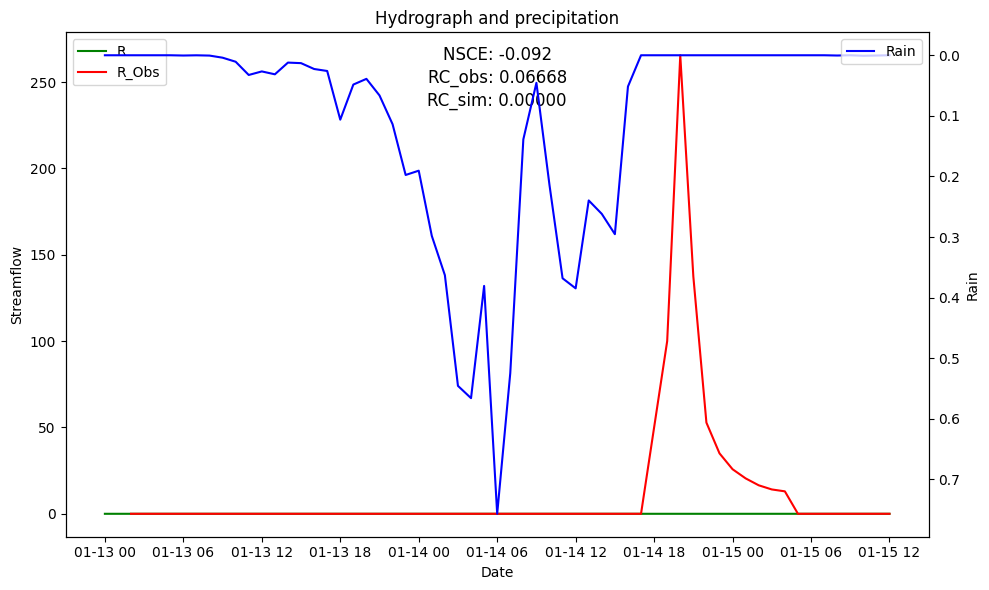

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
file_path = "./demo_project/output/Wadi_418.csv"
df = pd.read_csv(file_path)

# Step 2: Replace -9999 with NaN in the 'R_Obs' column
df['R_Obs'] = df['R_Obs'].replace(-9999, np.nan)

# Step 3: Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d:%H')

# Step 4: Plot the rain, R, and R_Obs in the same figure with rain on a separate axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Create a twin axis for the rain

# Plot R and R_Obs on the left axis
ax1.plot(df['Date'], df['R'], label='R', color='green')
ax1.plot(df['Date'], df['R_Obs'], label='R_Obs', color='red')

# Plotting rain upside down (inverted y-axis)
ax2.plot(df['Date'], df['rain'], label='Rain', color='blue')
ax2.set_ylim(ax2.get_ylim()[::-1])  # Invert the y-axis for rain

# Step 5: Calculate the NSCE (Nash-Sutcliffe Efficiency) between R and R_Obs (excluding NaN values)
observed = df['R_Obs'].values
simulated = df['R'].values
mask = (~np.isnan(observed)) & (~np.isnan(simulated))
nsce = 1 - np.sum((simulated[mask] - observed[mask]) ** 2) / np.sum((observed[mask] - np.nanmean(observed[mask])) ** 2)

# Step 4: Calculate the total basin area
basin_area = 149 * 166 * (500 ** 2)  # in square meters
total_obs_volume = np.nansum(df['R_Obs']) * 3600
total_sim_volume = np.nansum(df['R']) * 3600
rain_sum = np.nansum(df['rain'])
RC_obs = total_obs_volume / (rain_sum/1000 * basin_area)
RC_sim = total_sim_volume / (rain_sum/1000 * basin_area)

# Display the NSCE value on the plot (moved to the middle top)
ax1.text(df['Date'].iloc[int(len(df) / 2)], df['R_Obs'].max(), f'NSCE: {nsce:.3f}', fontsize=12, ha='center', va='center')
ax1.text(df['Date'].iloc[int(len(df) / 2)], df['R_Obs'].max()*0.95, f'RC_obs: {RC_obs:.5f}', fontsize=12, ha='center', va='center')
ax1.text(df['Date'].iloc[int(len(df) / 2)], df['R_Obs'].max()*0.90, f'RC_sim: {RC_sim:.5f}', fontsize=12, ha='center', va='center')

# Set plot properties
ax1.set_xlabel('Date')
ax1.set_ylabel('Streamflow')
ax2.set_ylabel('Rain')
ax1.set_title('Hydrograph and precipitation')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


## 3 Parameter sensitivity analysis

### 3.1 Soil properties adjustment

Adjust the soil properties based on a coefficient, export the adjusted files to a new folder for CREST simulation/calibration.

In [30]:
import os
import shutil
import rasterio

# Input and output directories
input_dir = "./demo_project/param/"
output_dir = "./demo_project/param/Adjust_07/"

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to apply the multiplier and save the adjusted raster
def adjust_raster(input_file, output_file, multiplier):
    with rasterio.open(input_file) as src:
        profile = src.profile
        data = src.read(1)  # Read the first band

        # Apply the multiplier
        adjusted_data = data * multiplier

        # Create the output file
        output_profile = profile.copy()
        output_profile['dtype'] = 'float32'  # Change the data type to float32 for adjusted data

        with rasterio.open(output_file, 'w', **output_profile) as dst:
            dst.write(adjusted_data, 1)

# List all files in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        input_file = os.path.join(root, file)
        output_file = os.path.join(output_dir, file)

        # If the file is a raster file with name starting with SAT, KSAT, FC, or Wwp
        if file.startswith("SAT") or file.startswith("KSAT") or file.startswith("FC") or file.startswith("Wwp"):
            # Apply the multiplier and save the adjusted raster
            adjust_raster(input_file, output_file, 0.7)
        else:
            # Copy all other files to the output directory if the output path does not exist in the output directory
            if not os.path.exists(output_file):
                shutil.copy(input_file, output_file)
